In [1]:
import sys
import os
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as ppl

import ivac
import extq

/Users/Spencer/anaconda3/envs/civsd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [36]:
plt.style.use("custom")  # custom style sheet (optional)
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
# diverging colormap from Paul Tol
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load data

In [5]:
DATA_DIR = "../../public/" # change this directory name as appropriate for your system
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)

# weights
weights = np.load(
    f"{DATA_DIR}/weights_3_feat5ivac.npy", allow_pickle=True
)[
    8
]  # 0.1 ns lag time

In [6]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

# Define states $A$ and $B$
See section E of Theory and Methods

In [8]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [9]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [10]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   5400
Number of other structures: 4106863


In [11]:
random.seed(123)

In [ ]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

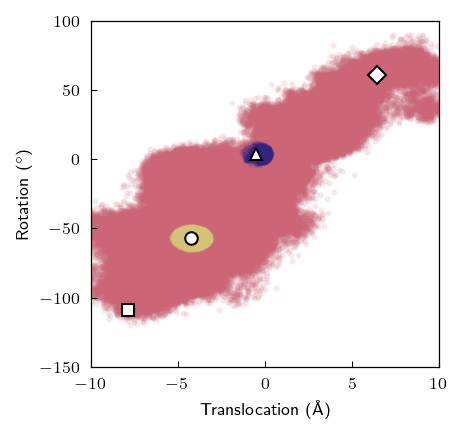

In [17]:
# plot points in A, B, and D
plt.scatter(other_cvs[::10, 0], other_cvs[::10, 1], alpha=0.1)
plt.scatter(up_cvs[::10, 0], up_cvs[::10, 1], alpha=0.1)
plt.scatter(down_cvs[::10, 0], down_cvs[::10, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

# Compute minimum distance in domain to states
These correspond to $d_A$ and $d_B$ in section F of Theory and Methods

In [19]:
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [20]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 1 # subsample for faster calculation

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.09% completed
0.17% completed
0.26% completed
0.34% completed
0.43% completed
0.51% completed
0.60% completed
0.68% completed
0.77% completed
0.85% completed
0.94% completed
1.03% completed
1.11% completed
1.20% completed
1.28% completed
1.37% completed
1.45% completed
1.54% completed
1.62% completed
1.71% completed
1.79% completed
1.88% completed
1.96% completed
2.05% completed
2.14% completed
2.22% completed
2.31% completed
2.39% completed
2.48% completed
2.56% completed
2.65% completed
2.73% completed
2.82% completed
2.90% completed
2.99% completed
3.08% completed
3.16% completed
3.25% completed
3.33% completed
3.42% completed
3.50% completed
3.59% completed
3.67% completed
3.76% completed
3.84% completed
3.93% completed
4.01% completed
4.10% completed
4.19% completed
4.27% completed
4.36% completed
4.44% completed
4.53% completed
4.61% completed
4.70% completed
4.78% completed
4.87% completed
4.95% completed
5.04% completed
5.13% completed
5.21% completed
5.30% completed
5.38% co

In [21]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(4150115, 1)


In [22]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, up[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.60% completed
1.20% completed
1.80% completed
2.40% completed
2.99% completed
3.59% completed
4.19% completed
4.79% completed
5.39% completed
5.99% completed
6.59% completed
7.19% completed
7.79% completed
8.38% completed
8.98% completed
9.58% completed
10.18% completed
10.78% completed
11.38% completed
11.98% completed
12.58% completed
13.18% completed
13.77% completed
14.37% completed
14.97% completed
15.57% completed
16.17% completed
16.77% completed
17.37% completed
17.97% completed
18.57% completed
19.16% completed
19.76% completed
20.36% completed
20.96% completed
21.56% completed
22.16% completed
22.76% completed
23.36% completed
23.96% completed
24.55% completed
25.15% completed
25.75% completed
26.35% completed
26.95% completed
27.55% completed
28.15% completed
28.75% completed
29.35% completed
29.94% completed
30.54% completed
31.14% completed
31.74% completed
32.34% completed
32.94% completed
33.54% completed
34.14% completed
34.74% completed
35.34% completed
35.93% comple

In [23]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(4150115, 1)


# Make smoothing and guess functions

In [24]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [25]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(4150115, 1) (4150115, 1) (4150115, 1)


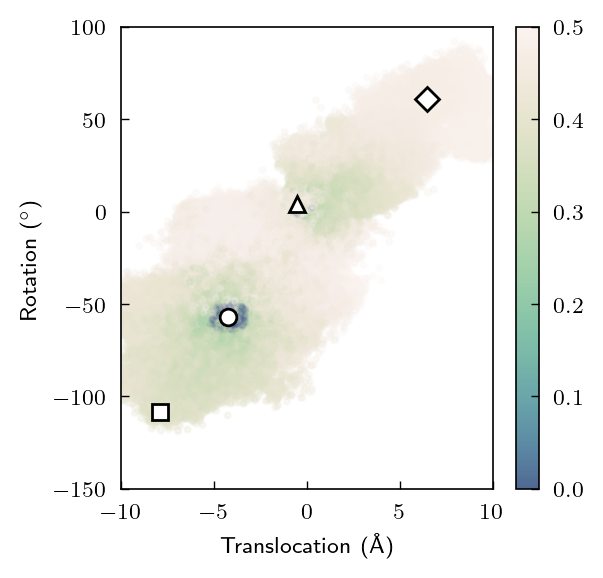

In [26]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap=cm_seq)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

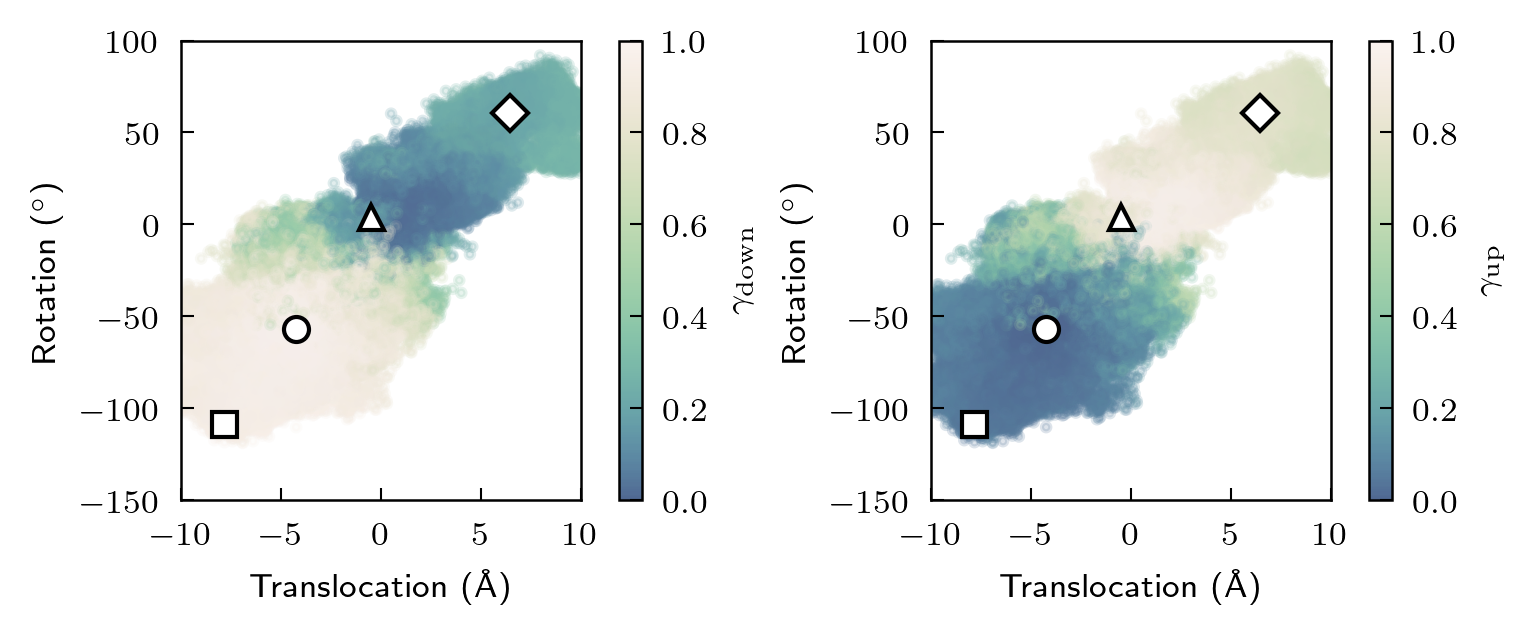

In [27]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=300, constrained_layout=True)
labels = ("$\gamma_{\mathrm{down}}$", "$\gamma_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2, cmap=cm_seq)
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.0)
    plotting.format_cvs(ax, ms=6)

# Weights

Weights are computed in `dga_220325.ipynb` using the method described. Since the raw data (features) used to compute the features are very large, we just supply the pointwise weights here.

# Make basis functions

In [28]:
# DGA package takes in lists of Numpy arrays
traj_inds = util.split_indices(cv_trajs)
traj_lens = [len(traj) for traj in cv_trajs]
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

# orthogonalize with respect to the stationary distribution
basis_d = util.orthogonalize(basisF, weights)

guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

352 (10000, 60)
352
352


# Perform committor calculation in DGA
For committors, we chose a lag time of 50 ns, or 500 time steps (configurations saved every 0.1 ns)

In [29]:
lag = 500

in_domain = np.split(mask, traj_inds)
print(len(in_domain), in_domain[0].shape)

# backward committor used for reactive currents
qp = extq.dga.forward_committor(basis_d, weights, in_domain, guessU, lag)
qm = extq.dga.backward_committor(basis_d, weights, in_domain, guessD, lag)

352 (10000,)


In [35]:
# compute E[\theta(x) S_tq_+(x)]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/Users/Spencer/anaconda3/envs/civsd/lib/python3.9/site-packages/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


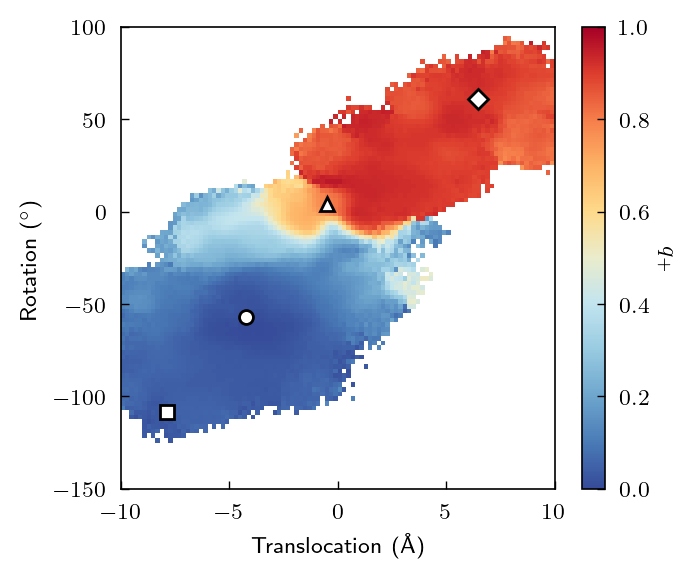

In [40]:
xlim = np.linspace(-10, 10, 101)
ylim = np.linspace(-150, 100, 101)
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2

q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xlim, ylim
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolormesh(xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=5)

# Compute reactive currents

This can also be done for projections onto other CVs besides the S4 helix translocation ($d$) and rotation ($\theta$)

In [31]:
d_trajs = [t[:, 0] for t in cv_trajs]
s_trajs = [t[:, 1] for t in cv_trajs]
j_d = extq.tpt.current(qp, qm, weights, in_domain, d_trajs, lag)
j_s = extq.tpt.current(qp, qm, weights, in_domain, s_trajs, lag)
j_ds = np.stack((j_d, j_s), axis=-1)

/Users/Spencer/anaconda3/envs/civsd/lib/python3.9/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


In [33]:
print(len(j_ds), j_ds[0].shape, j_ds[0][0].shape)

352 (2,) (10000,)


# (Optional) Save results

In [ ]:
np.save(f"{DATA_DIR}/qp.npy", qp)
np.save(f"{DATA_DIR}/qm.npy", qm)
np.save(f"{DATA_DIR}/current.npy", j_ds)